<a href="https://colab.research.google.com/github/dt1086/Kaggle---CommonLit-Readability-Prize/blob/master/CommonLit_Readability_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import neccessary libraries
import pandas as pd
import requests
import numpy as np
import json
from warnings import filterwarnings
filterwarnings('ignore')

import string
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import FreqDist

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.ensemble import AdaBoostRegressor

from keras.models import Sequential
from keras.layers import Dense

In [2]:
#Import the data
df = pd.read_csv('/content/sample_data/train.csv')
df

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845
...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128


In [3]:
df.drop(['id', 'url_legal', 'license'], axis=1, inplace=True)

In [4]:
X = df[['excerpt', 'standard_error']]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [5]:
pip install ktrain

     |████████████████████████████████| 25.3MB 120kB/s 
     |████████████████████████████████| 6.8MB 44.6MB/s 
     |████████████████████████████████| 983kB 44.2MB/s 
     |████████████████████████████████| 266kB 48.9MB/s 
     |████████████████████████████████| 1.9MB 35.9MB/s 
     |████████████████████████████████| 1.2MB 23.0MB/s 
     |████████████████████████████████| 471kB 41.9MB/s 
     |████████████████████████████████| 901kB 37.6MB/s 
     |████████████████████████████████| 3.3MB 34.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.4-cp37-none-any.whl size=25282461 sha256=8ef2f4ebebc4e628415c85b35bb45bd6dd08447ed81e99e04b38deb1f6afdf6d
  Stored in directory: /root/.cache/pip/wheels/95/cc/1b/84c3799864cd864b99d94a8aeac2ee2d928fb3d0ec3d3f1a13
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=2f27280c2d1f2e5ef60c31d054cf4ed5d76b198de02aa00c5ea95233f9553e67
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7d

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import ktrain
from ktrain import text

from transformers import AutoTokenizer, AutoModelWithLMHead
  
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

model = AutoModelWithLMHead.from_pretrained("xlnet-base-cased")

In [7]:
trans = text.Transformer('xlnet-base-cased', maxlen=512)
train_dataset = trans.preprocess_train(list(X_train['excerpt']), list(y_train))
test_dataset = trans.preprocess_test(list(X_test['excerpt']), list(y_test))

preprocessing train...
language: en
train sequence lengths:
	mean : 173
	95percentile : 198
	99percentile : 200


preprocessing test...
language: en
test sequence lengths:
	mean : 173
	95percentile : 198
	99percentile : 200


In [8]:
model = trans.get_regression_model()

learner = ktrain.get_learner(model, train_data=train_dataset, val_data=test_dataset, batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
354/354 [==============================] - 31s 31ms/step - loss: 1.7431 - mae: 1.0793


done.
Visually inspect loss plot and select learning rate associated with falling loss


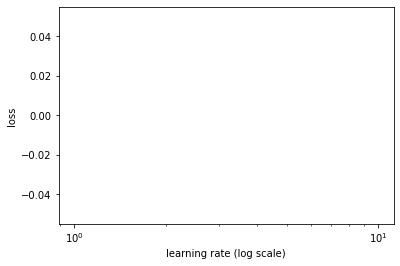

In [9]:
learner.lr_find(show_plot=True, max_epochs=10)

In [10]:
learner.fit_onecycle(1e-4, 1)



begin training using onecycle policy with max lr of 0.0001...
355/355 [==============================] - 638s 2s/step - loss: 0.5723 - mae: 0.5981 - val_loss: 0.3375 - val_mae: 0.4529


In [24]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [29]:
predictor.save('Model 1')